# CP3403 Data Mining
## Report: Credit Card Fraud

### Group: Matthew Marsh, Dannielle Jones and Callum Gracie

This data mining explores: A time series to see if there is a relationship between city population to fraud cases over time.

# Import Packages and Get Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from math import sqrt

In [2]:
data = pd.read_csv('../data/fraudTrain.csv')  # Read
#pd.set_option('display.float_format', lambda x:'%f'%x)  # Format

In [3]:
#print('Number of Records: {}'.format(len(data)))
print('Dataset rows: {} columns: {}'.format(data.shape[0], data.shape[1]))
data.head()

Dataset rows: 1296675 columns: 23


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


# Pre-Processing: NaN Data and Missing Data

In [4]:
# Check dataset for missing or NaN values
print('Dataset rows: {} columns: {}'.format(data.shape[0], data.shape[1]))
missing_values_count = data.isna().sum()
print(missing_values_count)

Dataset rows: 1296675 columns: 23
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


# Pre-Processing: Convert and Format Data

In [5]:
# View the unnamed column, then get and rename
print(data.iloc[:,0])
data = data.rename(columns={data.columns[0]: "column_id"})
data.set_index('column_id', inplace=True)
data.head()

0                0
1                1
2                2
3                3
4                4
            ...   
1296670    1296670
1296671    1296671
1296672    1296672
1296673    1296673
1296674    1296674
Name: Unnamed: 0, Length: 1296675, dtype: int64


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
column_id,,,,,,,,,,,,,,,,,,,,,
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [6]:
# Convert to numeric
data['amt'] = pd.to_numeric(data['amt'], errors='coerce')
data['zip'] = pd.to_numeric(data['zip'], errors='coerce')
data['lat'] = pd.to_numeric(data['lat'], errors='coerce')
data['long'] = pd.to_numeric(data['long'], errors='coerce')
data['city_pop'] = pd.to_numeric(data['city_pop'], errors='coerce')
data['merch_lat'] = pd.to_numeric(data['merch_long'], errors='coerce')
data['is_fraud'] = pd.to_numeric(data['is_fraud'], errors='coerce')

In [7]:
# Processing date of birth
data['dob'] = pd.to_datetime(data['dob'])  # convert to datetime object
data['year_of_birth'] = data['dob'].dt.year  # extract year
data['month_of_birth'] = data['dob'].dt.month  # extract month
data['day_of_birth'] = data['dob'].dt.day  # extract day
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,year_of_birth,month_of_birth,day_of_birth
column_id,,,,,,,,,,,,,,,,,,,,,
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,-82.048315,-82.048315,0,1988,3,9
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,-118.186462,-118.186462,0,1978,6,21
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,-112.154481,-112.154481,0,1962,1,19
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,-112.561071,-112.561071,0,1967,1,12
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,-78.632459,-78.632459,0,1986,3,28


In [8]:
# Processing transaction date and time
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])  # convert to datetime object
data['trans_year'] = data['trans_date_trans_time'].dt.year  # extract year
data['trans_month'] = data['trans_date_trans_time'].dt.month  # extract month
data['trans_day'] = data['trans_date_trans_time'].dt.day  # extract day
data['trans_time'] = data['trans_date_trans_time'].dt.time  # extract time
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,merch_lat,merch_long,is_fraud,year_of_birth,month_of_birth,day_of_birth,trans_year,trans_month,trans_day,trans_time
column_id,,,,,,,,,,,,,,,,,,,,,
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-82.048315,-82.048315,0,1988,3,9,2019,1,1,00:00:18
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.186462,-118.186462,0,1978,6,21,2019,1,1,00:00:44
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.154481,-112.154481,0,1962,1,19,2019,1,1,00:00:51
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.561071,-112.561071,0,1967,1,12,2019,1,1,00:01:16
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-78.632459,-78.632459,0,1986,3,28,2019,1,1,00:03:06


In [9]:
# Processing Gender into binary
gender_count = data['gender'].value_counts()
data['is_female'] = data['gender'].apply(lambda x: 1 if x.upper() == "F" else 0)
is_female_count = data['is_female'].value_counts()
print("Gender Count: \n{}".format(gender_count))
print("is_female Count: \n{}".format(is_female_count))
data.head()

Gender Count: 
F    709863
M    586812
Name: gender, dtype: int64
is_female Count: 
1    709863
0    586812
Name: is_female, dtype: int64


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,merch_long,is_fraud,year_of_birth,month_of_birth,day_of_birth,trans_year,trans_month,trans_day,trans_time,is_female
column_id,,,,,,,,,,,,,,,,,,,,,
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-82.048315,0,1988,3,9,2019,1,1,00:00:18,1
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.186462,0,1978,6,21,2019,1,1,00:00:44,1
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.154481,0,1962,1,19,2019,1,1,00:00:51,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.561071,0,1967,1,12,2019,1,1,00:01:16,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-78.632459,0,1986,3,28,2019,1,1,00:03:06,0


In [10]:
sub1 = data.copy()

# Pre-Processing: Create Data Sub-Set

In [11]:
# Reduce sample size for computation: Get random sub-sample
np.random.seed(42)
sub_fraction = 0.01

random_fraction_sub = sub1.sample(frac=sub_fraction, random_state=42)
print(f"Current size of data: {len(sub1)} \n")
print(f"Records Count: {len(random_fraction_sub)}")

sub1 = random_fraction_sub
print('Subset rows: {} columns: {}'.format(sub1.shape[0], sub1.shape[1]))
sub1.head()

Current size of data: 1296675 

Records Count: 12967
Subset rows: 12967 columns: 30


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,merch_long,is_fraud,year_of_birth,month_of_birth,day_of_birth,trans_year,trans_month,trans_day,trans_time,is_female
column_id,,,,,,,,,,,,,,,,,,,,,
1045211,2020-03-09 15:09:26,577588686219,fraud_Towne LLC,misc_pos,194.51,James,Strickland,M,25454 Leonard Lake,Spring Church,...,-78.865012,0,1997,10,23,2020,3,9,15:09:26,0
547406,2019-08-22 15:49:01,30376238035123,fraud_Friesen Ltd,health_fitness,52.32,Cynthia,Davis,F,7177 Steven Forges,Sixes,...,-123.636337,0,1928,10,1,2019,8,22,15:49:01,1
110142,2019-03-04 01:34:16,4658490815480264,fraud_Mohr Inc,shopping_pos,6.53,Tara,Richards,F,4879 Cristina Station,Keisterville,...,-78.898190,0,1945,11,4,2019,3,4,01:34:16,1
1285953,2020-06-16 20:04:38,3514897282719543,fraud_Gaylord-Powlowski,home,7.33,Steven,Faulkner,M,841 Cheryl Centers Suite 115,Farmington,...,-76.542384,0,1952,10,13,2020,6,16,20:04:38,0
271705,2019-05-14 05:54:48,6011381817520024,"fraud_Christiansen, Goyette and Schamberger",gas_transport,64.29,Kristen,Allen,F,8619 Lisa Manors Apt. 871,Lagrange,...,-104.092324,0,1973,7,13,2019,5,14,05:54:48,1


In [12]:
# Check how many cases are fraud
is_fraud_count = sub1[(sub1['is_fraud'] == 1)]
print('Fraud count: {}'.format(len(is_fraud_count)))
is_not_fraud_count = sub1[(sub1['is_fraud'] != 1)]
print('Non-Fraud count: {}'.format(len(is_not_fraud_count)))
is_fraud_count.head()

Fraud count: 70
Non-Fraud count: 12897


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,merch_long,is_fraud,year_of_birth,month_of_birth,day_of_birth,trans_year,trans_month,trans_day,trans_time,is_female
column_id,,,,,,,,,,,,,,,,,,,,,
307415,2019-05-29 03:20:26,213124978348176,fraud_Murray Ltd,grocery_net,15.95,Steven,Arnold,M,079 Chelsea Rest,Belfast,...,-78.747801,1,1962,6,4,2019,5,29,03:20:26,0
1049132,2020-03-10 19:42:02,3546674063249004,"fraud_Zboncak, Rowe and Murazik",shopping_net,1047.60,Jordan,May,M,1626 Susan Course,Aledo,...,-98.271148,1,1984,7,5,2020,3,10,19:42:02,0
778318,2019-11-29 23:01:08,4736845434667908128,"fraud_Schmeler, Bashirian and Price",shopping_net,828.37,Toni,Gomez,F,062 Carl Dam,Altona,...,-74.157311,1,1953,5,23,2019,11,29,23:01:08,1
1248615,2020-06-03 22:43:46,4538566639857,fraud_Kerluke-Abshire,shopping_net,1091.97,Jerry,Kelly,M,3539 Mckenzie Stream,Fairview,...,-74.132459,1,1967,5,28,2020,6,3,22:43:46,0
922221,2019-12-31 02:54:26,213155997615567,fraud_Miller-Hauck,grocery_pos,293.09,James,Yoder,M,83359 Lopez Point,Clune,...,-79.352258,1,1978,10,4,2019,12,31,02:54:26,0


In [13]:
sub1 = sub1[(sub1['is_fraud'] == 1)]
sub2 = sub1.copy()

# Data Mining Technique/Method: Time Series
## Visualisation: Pre-Processing

In [14]:
# Set date/time as index and sub-sample relevant columns
sub2['trans_date'] = sub2['trans_date_trans_time'].dt.date  # extract date
sub2['trans_date'] = pd.to_datetime((sub2['trans_date']))
sub2.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,is_fraud,year_of_birth,month_of_birth,day_of_birth,trans_year,trans_month,trans_day,trans_time,is_female,trans_date
column_id,,,,,,,,,,,,,,,,,,,,,
307415,2019-05-29 03:20:26,213124978348176,fraud_Murray Ltd,grocery_net,15.95,Steven,Arnold,M,079 Chelsea Rest,Belfast,...,1,1962,6,4,2019,5,29,03:20:26,0,2019-05-29
1049132,2020-03-10 19:42:02,3546674063249004,"fraud_Zboncak, Rowe and Murazik",shopping_net,1047.60,Jordan,May,M,1626 Susan Course,Aledo,...,1,1984,7,5,2020,3,10,19:42:02,0,2020-03-10


In [15]:
sub2.set_index('trans_date', inplace=True)
sub2.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,merch_long,is_fraud,year_of_birth,month_of_birth,day_of_birth,trans_year,trans_month,trans_day,trans_time,is_female
trans_date,,,,,,,,,,,,,,,,,,,,,
2019-05-29,2019-05-29 03:20:26,213124978348176,fraud_Murray Ltd,grocery_net,15.95,Steven,Arnold,M,079 Chelsea Rest,Belfast,...,-78.747801,1,1962,6,4,2019,5,29,03:20:26,0
2020-03-10,2020-03-10 19:42:02,3546674063249004,"fraud_Zboncak, Rowe and Murazik",shopping_net,1047.60,Jordan,May,M,1626 Susan Course,Aledo,...,-98.271148,1,1984,7,5,2020,3,10,19:42:02,0


In [16]:
sub2 = sub2[['city_pop', 'is_fraud', 'trans_year', 'trans_month']].copy()
sub2 = sub2.sort_values(by='trans_date')

In [17]:
sub2.head(2)  # View start date

,city_pop,is_fraud,trans_year,trans_month
trans_date,,,,
2019-01-02,1595797,1,2019,1
2019-01-03,1472,1,2019,1


In [18]:
sub2.tail(2)  # View end date

,city_pop,is_fraud,trans_year,trans_month
trans_date,,,,
2020-05-24,331,1,2020,5
2020-06-03,13835,1,2020,6


In [19]:
# Slice specific time frame
date_range_from = '2019-06-01'
date_range_to = '2020-06-01'
select_year = '2019'

transaction_all_data = sub2.copy()  # All dates
# transaction_all_data.reset_index(inplace=True)
# transaction_all_data.set_index('trans_year', inplace=True)
transaction_all_data.head()

,city_pop,is_fraud,trans_year,trans_month
trans_date,,,,
2019-01-02,1595797,1,2019,1
2019-01-03,1472,1,2019,1
2019-01-15,205,1,2019,1
2019-01-15,3285,1,2019,1
2019-01-27,22305,1,2019,1


In [20]:
transaction_range_data = sub2[date_range_from:date_range_to]  # Range of date
# transaction_range_data.reset_index(inplace=True)
# transaction_range_data.set_index('trans_year', inplace=True)
transaction_range_data.tail()

,city_pop,is_fraud,trans_year,trans_month
trans_date,,,,
2020-05-03,4677,1,2020,5
2020-05-09,749635,1,2020,5
2020-05-11,1195,1,2020,5
2020-05-12,1195,1,2020,5
2020-05-24,331,1,2020,5


In [21]:
transaction_year_data = sub2.loc[select_year]  # Specific year
# transaction_year_data.reset_index(inplace=True)
# transaction_year_data.set_index('trans_month', inplace=True)
transaction_year_data.head()

,city_pop,is_fraud,trans_year,trans_month
trans_date,,,,
2019-01-02,1595797,1,2019,1
2019-01-03,1472,1,2019,1
2019-01-15,205,1,2019,1
2019-01-15,3285,1,2019,1
2019-01-27,22305,1,2019,1


## Visualisation: Plots/Graphs

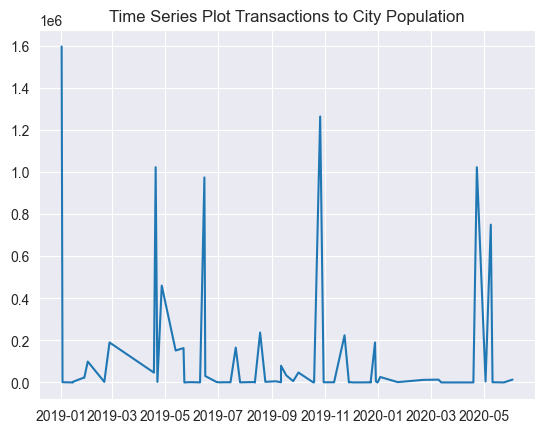

In [22]:
%matplotlib inline

# Plot of transaction data - all
plt.title("Time Series Plot Transactions to City Population")
plt.plot(transaction_all_data['city_pop'])

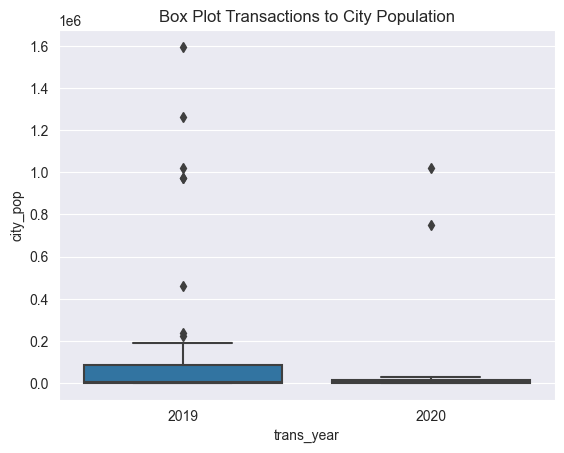

In [23]:
plt.title("Box Plot Transactions to City Population")
ax = sns.boxplot(data=transaction_all_data, x='trans_year', y='city_pop')

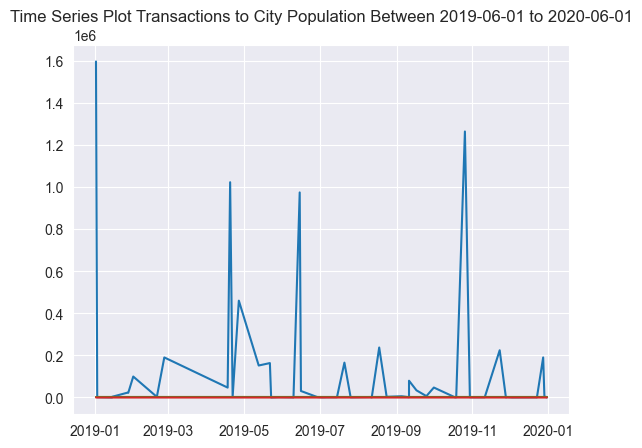

In [24]:
# Plot of transaction data - date range
plt.title(f"Time Series Plot Transactions to City Population Between {date_range_from} to {date_range_to}")
plt.plot(transaction_year_data)

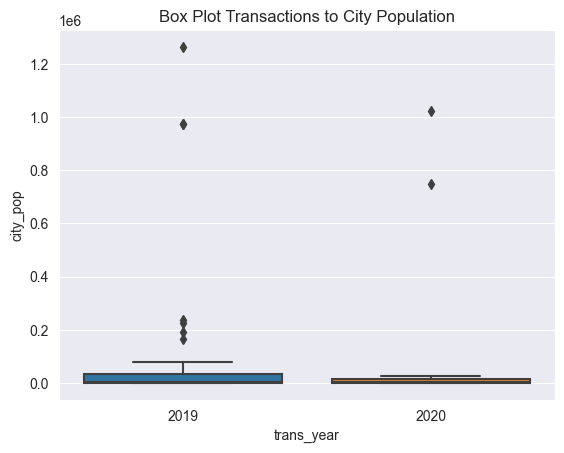

In [25]:
plt.title("Box Plot Transactions to City Population")
ax3 = sns.boxplot(data=transaction_range_data, x='trans_year', y='city_pop')

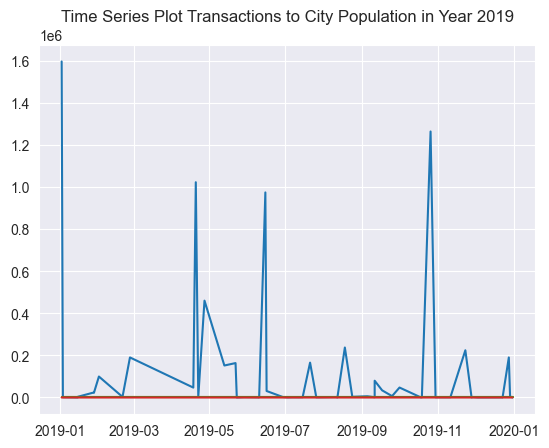

In [26]:
# Plot of transaction data - year
plt.title(f"Time Series Plot Transactions to City Population in Year {select_year}")
plt.plot(transaction_year_data)

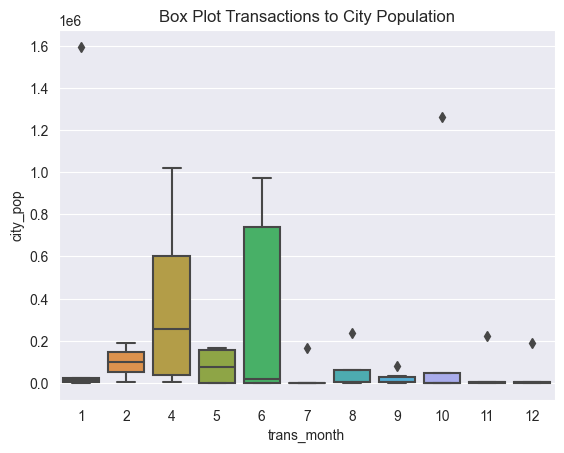

In [27]:
plt.title("Box Plot Transactions to City Population")
ax2 = sns.boxplot(data=transaction_year_data, x='trans_month', y='city_pop')

### Stationary Check

In [28]:
# Perform Stationary Test
def test_stationary(timeseries, number_of_months):

    #Determing rolling statistics
    rolling_mean = timeseries.rolling(window=number_of_months).mean()
    rolling_std = timeseries.rolling(window=number_of_months).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

Stationary Test - ALl Data


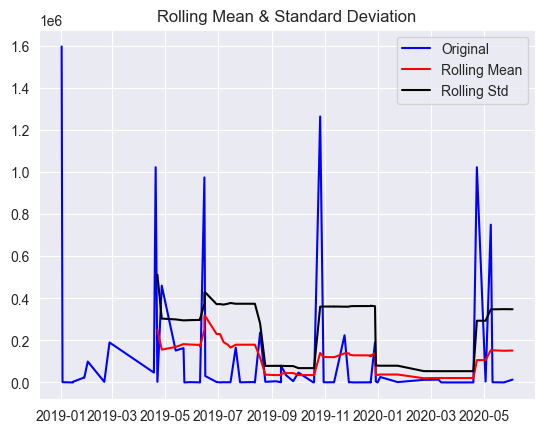


Stationary Test - Range 2019-06-01 to 2020-06-01


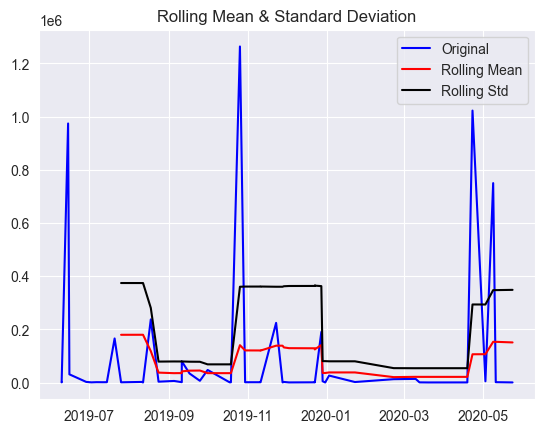


Stationary Test - Year 2019


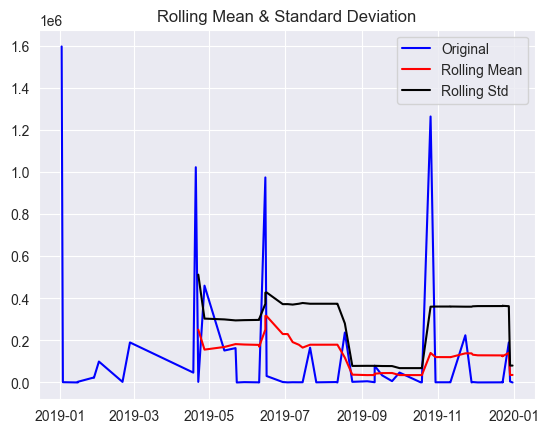

In [29]:
print("Stationary Test - ALl Data")
test_stationary(transaction_all_data['city_pop'], 12)
print()

print(f"Stationary Test - Range {date_range_from} to {date_range_to}")
test_stationary(transaction_range_data['city_pop'], 12)
print()

print(f"Stationary Test - Year {select_year}")
test_stationary(transaction_year_data['city_pop'], 12)
print()

In [30]:
# Perform Dickey-Fuller Test
def test_dickey_fuller(timeseries):
    print('Results of Dickey-Fuller Test:')
    df_test = adfuller(timeseries, autolag='AIC')

    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    print (df_output)

In [31]:
print("Dickey Fuller Test - ALl Data")
test_dickey_fuller(transaction_all_data['city_pop'])
print()

print(f"Dickey Fuller Test - Range {date_range_from} to {date_range_to}")
test_dickey_fuller(transaction_range_data['city_pop'])
print()

print(f"Dickey Fuller Test - Year {select_year}")
test_dickey_fuller(transaction_year_data['city_pop'])
print()

Dickey Fuller Test - ALl Data
Results of Dickey-Fuller Test:
Test Statistic                -9.647149e+00
p-value                        1.467459e-16
#Lags Used                     0.000000e+00
Number of Observations Used    6.900000e+01
Critical Value (1%)           -3.528890e+00
Critical Value (5%)           -2.904440e+00
Critical Value (10%)          -2.589656e+00
dtype: float64

Dickey Fuller Test - Range 2019-06-01 to 2020-06-01
Results of Dickey-Fuller Test:
Test Statistic                -6.600835e+00
p-value                        6.742445e-09
#Lags Used                     0.000000e+00
Number of Observations Used    5.100000e+01
Critical Value (1%)           -3.565624e+00
Critical Value (5%)           -2.920142e+00
Critical Value (10%)          -2.598015e+00
dtype: float64

Dickey Fuller Test - Year 2019
Results of Dickey-Fuller Test:
Test Statistic                -8.633111e+00
p-value                        5.684869e-14
#Lags Used                     0.000000e+00
Number of Obse

#### Conclusions:
All data test: The p-value indicates that we reject the null hypothesis of non-stationary, indicating that the data is stationary.
Range data test: The p-value indicates that we reject the null hypothesis of non-stationary, indicating that the data is stationary.
Year data test: The p-value indicates that we reject the null hypothesis of non-stationary, indicating that the data is stationary.

### Auto-correlation

In [32]:
# Perform auto-correlation lag
def auto_correlation_lag(dataframe, column_name, number_of_months):
    """
    Perform auto correlation lag
    :param dataframe:
    :param column_name:
    :param number_of_months:
    :return: auto lag correlation by number of months
    """
    return dataframe[column_name].autocorr(lag=number_of_months)

In [33]:
lag_month_number = 1

print(f"All Data - {lag_month_number} Month Lag: {auto_correlation_lag(transaction_all_data, 'city_pop', lag_month_number)}")
print(f"Range {date_range_from} to {date_range_to} Data - {lag_month_number} Month Lag: {auto_correlation_lag(transaction_all_data, 'city_pop', lag_month_number)}")
print(f"Year {select_year } Data - {lag_month_number} Month Lag: {auto_correlation_lag(transaction_all_data, 'city_pop', lag_month_number)}")

All Data - 1 Month Lag: -0.004818203526160265
Range 2019-06-01 to 2020-06-01 Data - 1 Month Lag: -0.004818203526160265
Year 2019 Data - 1 Month Lag: -0.004818203526160265


#### Conclusions:
All data lag: Indicates a weak negative linear dependence between observations that are 1 month apart. There is little correlation between consecutive months in the data.
Range data lag: Indicates a weak negative linear dependence between observations that are 1 month apart. There is little correlation between consecutive months in the data.
Year data lag: Indicates a weak negative linear dependence between observations that are 1 month apart. There is little correlation between consecutive months in the data.

### Decomposition

In [34]:
# Get log to make patterns or trends more apparent
def get_log(dataframe, column_name):
    """
    Find log by dataframe and column name
    :param dataframe:
    :param column_name:
    :return: log
    """
    return np.log(dataframe[column_name])

In [35]:
ts_log_all = get_log(transaction_all_data, 'city_pop')
ts_log_range = get_log(transaction_range_data, 'city_pop')
ts_log_year = get_log(transaction_year_data, 'city_pop')

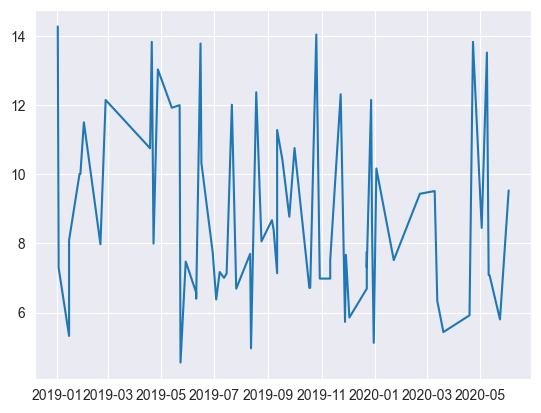

In [36]:
plt.plot(ts_log_all)

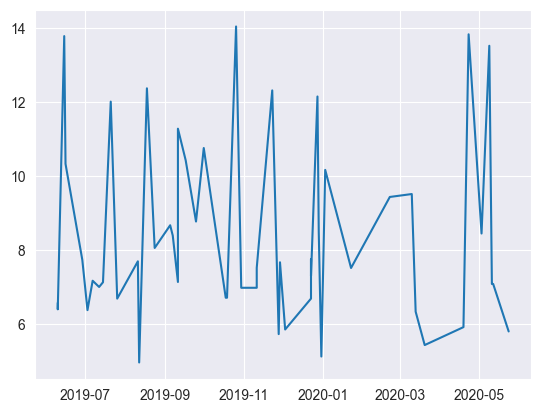

In [37]:
plt.plot(ts_log_range)

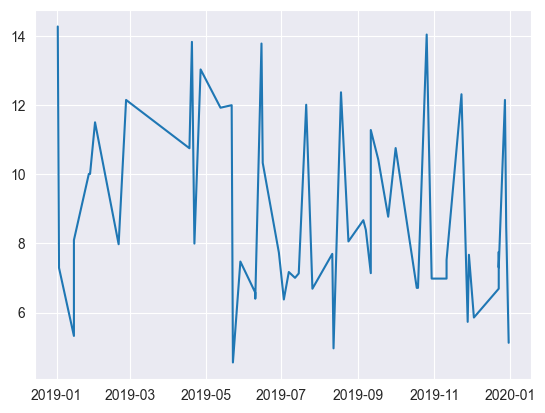

In [38]:
plt.plot(ts_log_year)

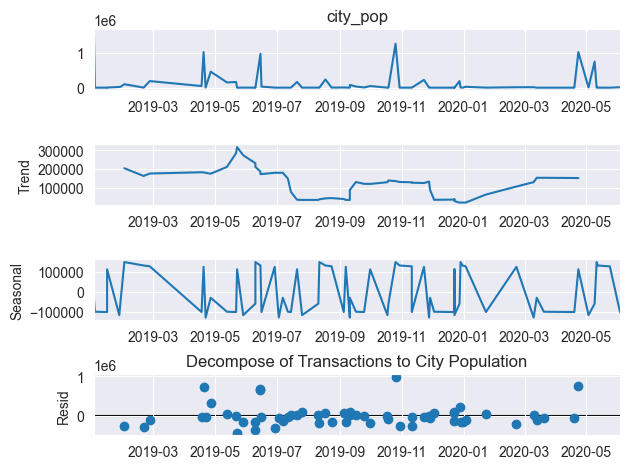

In [39]:
decompose_all = seasonal_decompose(transaction_all_data['city_pop'], model='additive', period=12)
decompose_all.plot()
plt.title("Decompose of Transactions to City Population")
plt.show()

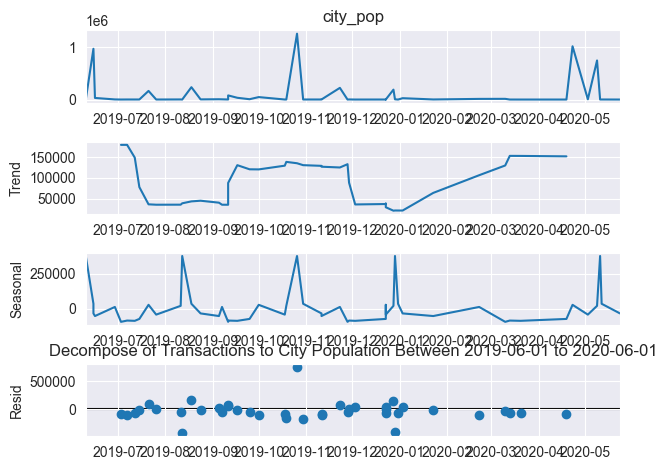

In [40]:
decompose_range = seasonal_decompose(transaction_range_data['city_pop'], model='additive', period=12)
decompose_range.plot()
plt.title(f"Decompose of Transactions to City Population Between {date_range_from} to {date_range_to}")
plt.show()

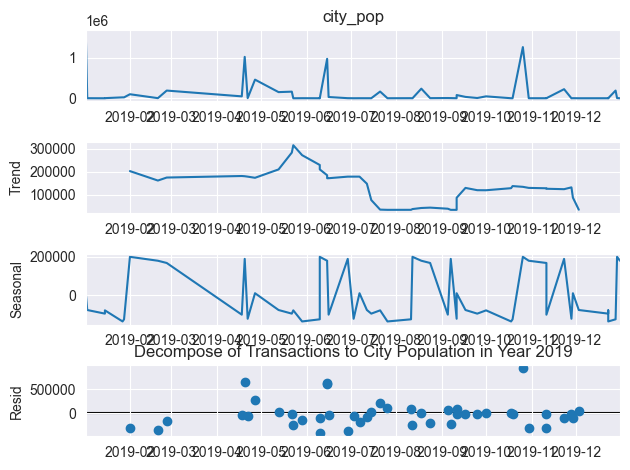

In [41]:
decompose_year = seasonal_decompose(transaction_year_data['city_pop'], model='additive', period=12)
decompose_year.plot()
plt.title(f"Decompose of Transactions to City Population in Year {select_year}")
plt.show()

#### Conclusion:
There is very little trend seen in any of the data.

### Forecasting

In [42]:
# Split into train and test data
train = transaction_all_data['2019-06-01':'2019-12-01'].copy()
train['train'] = train['city_pop']
train = train[['train']]

test = transaction_all_data['2019-12-01':'2020-06-01'].copy()
test['train'] = test['city_pop']
test = test[['train']]

In [43]:
train.head()

,train
trans_date,
2019-06-10,718
2019-06-10,602
2019-06-15,973849
2019-06-15,973849
2019-06-16,30770


In [44]:
test.head()

,train
trans_date,
2019-12-03,349
2019-12-23,805
2019-12-23,2328
2019-12-23,1490
2019-12-28,190178


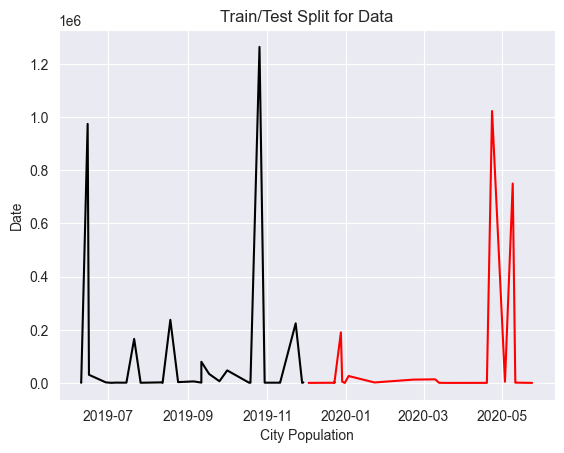

In [45]:
# Plot the training and test data prediction
plt.plot(train, color='black')
plt.plot(test, color='red')
plt.title('Train/Test Split for Data')
plt.xlabel('City Population')
plt.ylabel('Date')
sns.set()
plt.show()

In [46]:
# Construct ARIMA model
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=904.511, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=905.859, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=909.298, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=907.423, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=911.212, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.216 seconds


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


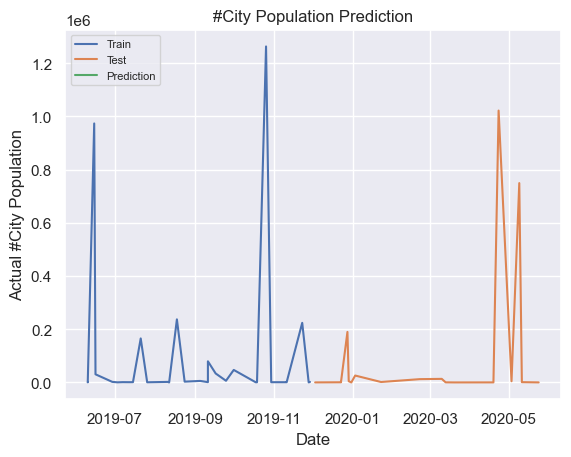

In [47]:
# Display model
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction')
plt.title('#City Population Prediction')
plt.xlabel('Date')
plt.ylabel('Actual #City Population')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [48]:
# Calculate root mean squared error
test = test.dropna()
forecast = forecast.dropna()
print("Length of test:", len(test))
print("Length of forecast:", len(forecast))

Length of test: 20
Length of forecast: 0


In [49]:
# rmse = sqrt(mean_squared_error(test, forecast))
# print("RMSE: ", rmse)

## Discussion: Visualisation: Results and Data
Time series has not been useful to identify patterns regarding fraud cases to city population. The forecast length of 0 indicates that model did not generate any meaningful predictions so mean_squared_error test was not required.